In [1]:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [2]:
!pip install neuralprophet[live]
!pip install holidays

     |████████████████████████████████| 74 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 18.5 MB 136 kB/s eta 0:00:01    |████████████▋                   | 7.2 MB 3.4 MB/s eta 0:00:04
     |████████████████████████████████| 1.8 MB 558 kB/s eta 0:00:01


In [3]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
#from sklearn.pipeline import Pipeline
from neuralprophet import NeuralProphet
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, PredefinedSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import holidays
import numpy as np

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Преобразование-и-поиск-пропусков" data-toc-modified-id="Преобразование-и-поиск-пропусков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Преобразование и поиск пропусков</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#NeuralProphet" data-toc-modified-id="NeuralProphet-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>NeuralProphet</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#NeuralProphet" data-toc-modified-id="NeuralProphet-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>NeuralProphet</a></span></li><li><span><a href="#Лучшая-модель" data-toc-modified-id="Лучшая-модель-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Лучшая модель</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Загрузка данных

In [4]:
df = pd.read_csv('/datasets/taxi.csv',parse_dates=['datetime'])
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
df['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

In [7]:
df['datetime'].describe(datetime_is_numeric=True)

count                  26496
mean     2018-05-31 23:55:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:57:30
50%      2018-05-31 23:55:00
75%      2018-07-16 23:52:30
max      2018-08-31 23:50:00
Name: datetime, dtype: object

Предоставлена информация за полгода, нули заполнены, что хорошо.

### Преобразование и поиск пропусков

In [8]:
df = df.set_index('datetime').sort_index()
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [9]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Нужно удостовериться, что в данных нет пропусков. Если пропуски имеются, то значения будут заполнены нулями как отсутствие заказов такси.

In [10]:
r = pd.date_range(start=df.index.min(), end=df.index.max(),freq='H')
r, ('Количество часов совпадает',len(r)==len(df))

(DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
                '2018-03-01 02:00:00', '2018-03-01 03:00:00',
                '2018-03-01 04:00:00', '2018-03-01 05:00:00',
                '2018-03-01 06:00:00', '2018-03-01 07:00:00',
                '2018-03-01 08:00:00', '2018-03-01 09:00:00',
                ...
                '2018-08-31 14:00:00', '2018-08-31 15:00:00',
                '2018-08-31 16:00:00', '2018-08-31 17:00:00',
                '2018-08-31 18:00:00', '2018-08-31 19:00:00',
                '2018-08-31 20:00:00', '2018-08-31 21:00:00',
                '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
               dtype='datetime64[ns]', length=4416, freq='H'),
 ('Количество часов совпадает', True))

Пропусков в датах нет.

## Анализ

<AxesSubplot:xlabel='datetime'>

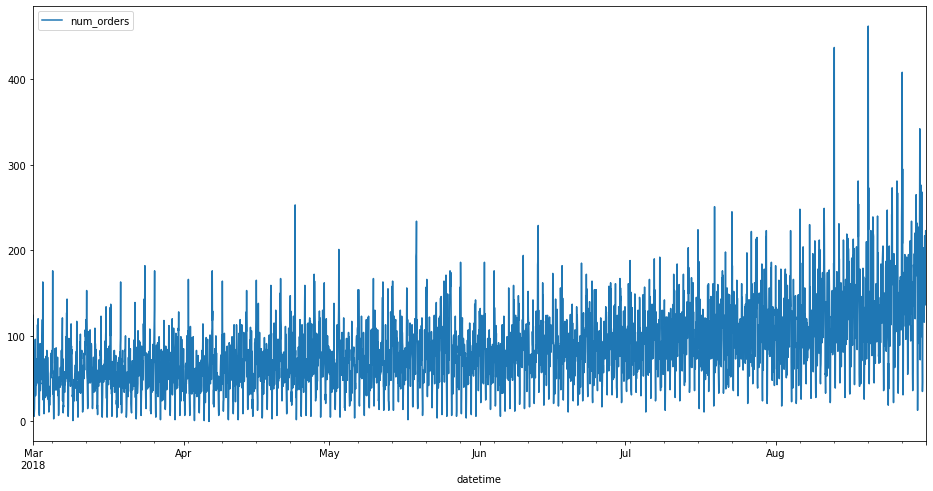

In [11]:
df.plot(figsize=(16, 8))

In [12]:
decomposed = seasonal_decompose(df)

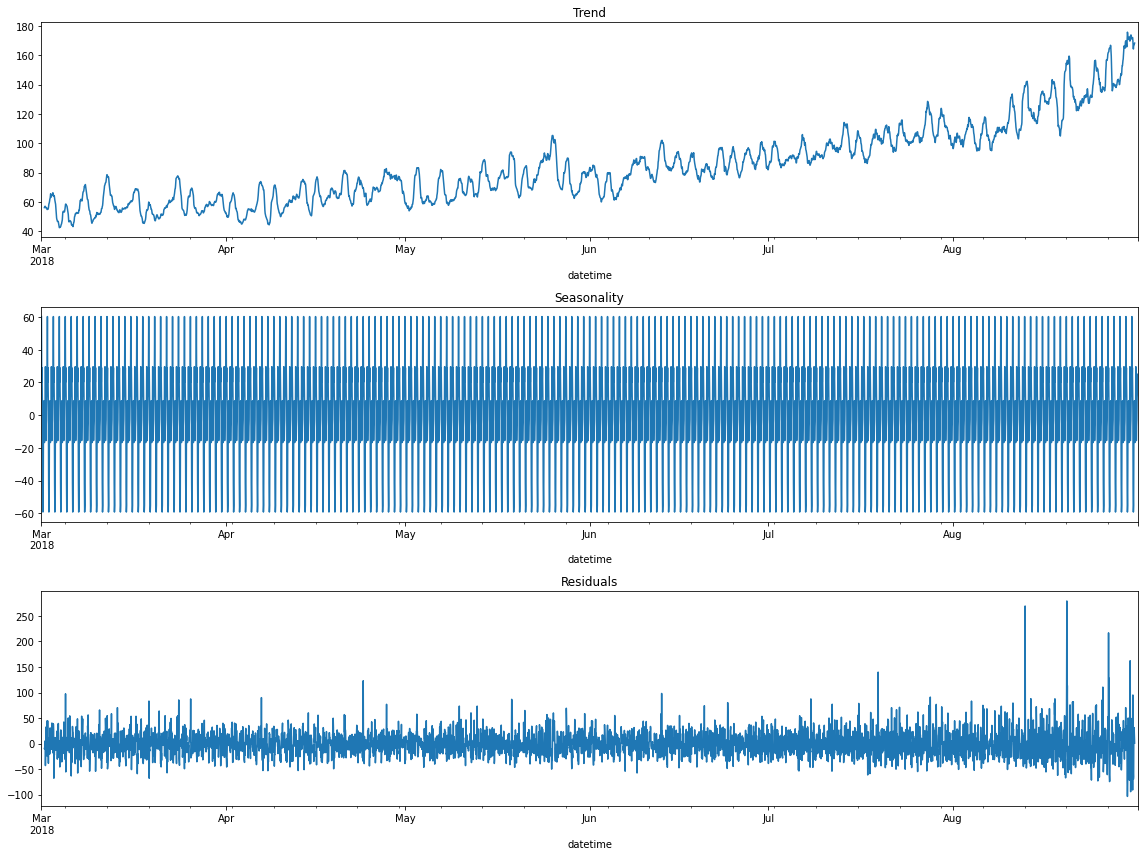

In [13]:
plt.figure(figsize=(16, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Чётко прослеживаются тренд и сезонность.

<AxesSubplot:xlabel='datetime'>

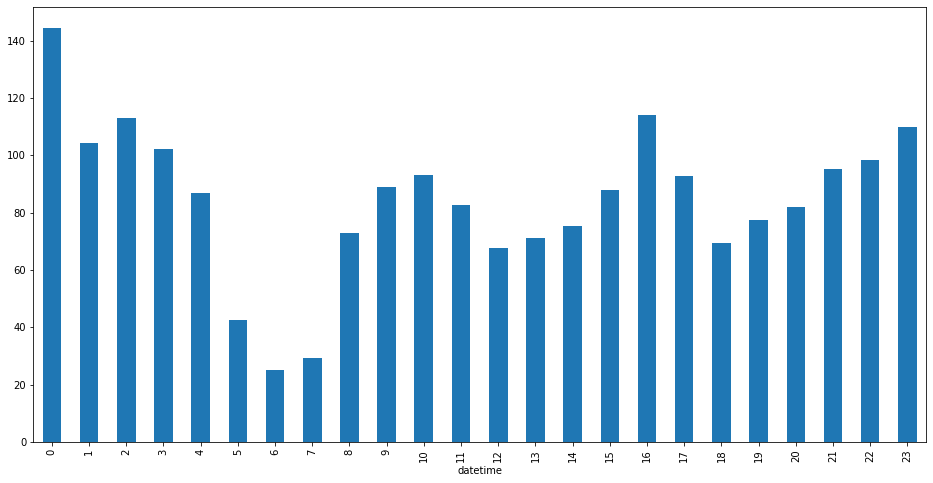

In [14]:
df.groupby(df.index.hour)['num_orders'].mean().plot.bar(figsize=(16, 8))

<AxesSubplot:xlabel='datetime'>

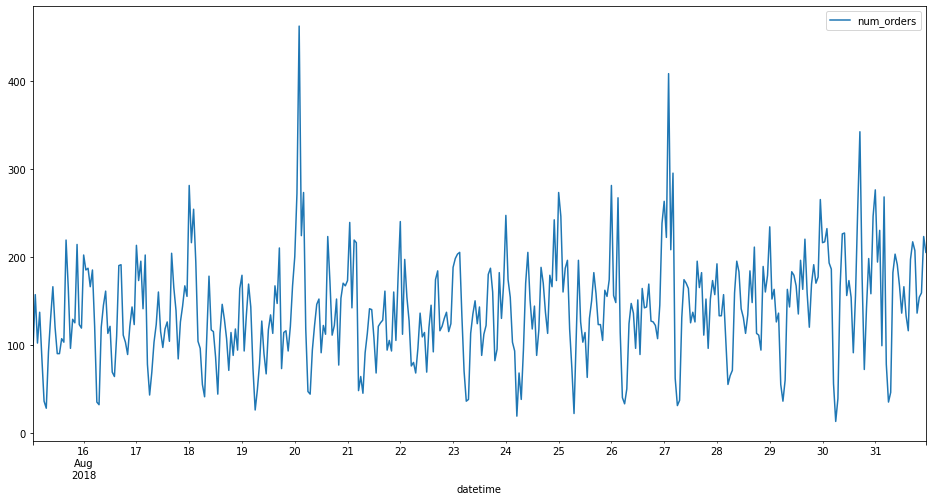

In [15]:
df[df.index > '2018-08-15'].plot(figsize=(16, 8))

На графиках очень хорошо видно сильную зависимость от времени дня.

<AxesSubplot:xlabel='datetime'>

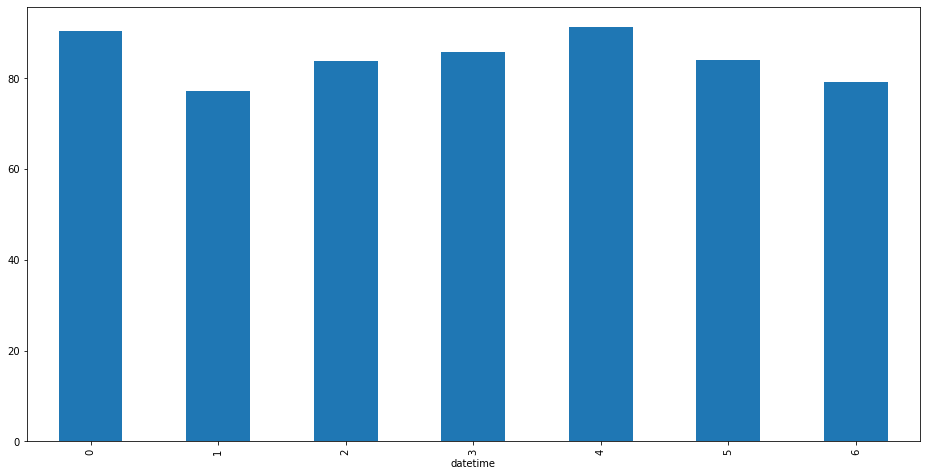

In [16]:
df.groupby(df.index.day_of_week)['num_orders'].mean().plot.bar(figsize=(16, 8))

Зависимость от дня недели не очень сильная, но изменения заметны.

<div class="alert alert-block alert-success">
<b>Успех:</b> В целом, этот шаг был сделан хорошо.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Однако, сезонность стоит визуализировать на более коротком интервале (н-р неделя).
</div>

## Обучение

### GradientBoostingRegressor

Модель требует создание новых признаков. Для возможности использования модели в течение нескольких лет, будет добавлен год. Также может понадобиться проверка на празаничные дни.

In [17]:
holidays = holidays.RU()

In [18]:
def make_features(x,rolling = 24, max_lag = 24):
    x['rolling_mean'] = x['num_orders'].shift().rolling(rolling).mean()
    for lag in range(1, max_lag + 1):
        x[f'lag_{lag}'] = x['num_orders'].shift(lag)

    x['year'] = x.index.year
    x['month'] = x.index.month
    x['day'] = x.index.day
    x['hour'] = x.index.hour
    x['day_of_week'] = x.index.day_of_week
    x['is_holiday'] = x.index.map(lambda x: x in holidays)
    x.dropna(inplace=True)

<div class="alert alert-block alert-success">
<b>Успех (ревью 3):</b> Верно!
</div>

In [19]:
data = df.copy()
make_features(data)
data

,num_orders,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_21,lag_22,lag_23,lag_24,year,month,day,hour,day_of_week,is_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,56.833333,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,66.0,71.0,85.0,124.0,2018,3,2,0,4,False
2018-03-02 01:00:00,120,55.416667,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,43.0,66.0,71.0,85.0,2018,3,2,1,4,False
2018-03-02 02:00:00,75,56.875000,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,6.0,43.0,66.0,71.0,2018,3,2,2,4,False
2018-03-02 03:00:00,64,57.041667,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,12.0,6.0,43.0,66.0,2018,3,2,3,4,False
2018-03-02 04:00:00,20,56.958333,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,15.0,12.0,6.0,43.0,2018,3,2,4,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,...,158.0,198.0,142.0,72.0,2018,8,31,19,4,False
2018-08-31 20:00:00,154,167.541667,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,246.0,158.0,198.0,142.0,2018,8,31,20,4,False
2018-08-31 21:00:00,159,168.041667,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,276.0,246.0,158.0,198.0,2018,8,31,21,4,False


In [20]:
data['is_holiday'].sum()

96

In [21]:
train, test = train_test_split(data, test_size=0.1,shuffle = False)

In [22]:
features_train = train.drop(['num_orders'],axis = 1)
target_train = train['num_orders']
#features_valid = valid .drop(['num_orders'],axis = 1)
#target_valid  = valid['num_orders']
features_test = test.drop(['num_orders'],axis = 1)
target_test = test['num_orders']
#data_features = data.drop(['num_orders'],axis = 1)
#data_target = data['num_orders']

In [24]:
sp = TimeSeriesSplit()
#test_ind = np.concatenate([[-1 for x in range(len(train))],[0 for x in range(len(test))]])

In [25]:
#sp = PredefinedSplit(test_ind)

In [32]:
%%time
parameters = {'min_samples_leaf':[1,2,3], 'max_depth':[2,3,4,5],'random_state':[13]}

model = GradientBoostingRegressor()
clf = GridSearchCV(model, param_grid=parameters, scoring='neg_mean_squared_error', verbose=1,refit=1)

clf.fit(features_train, target_train)

params = clf.best_params_
params

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 1min 22s, sys: 64.4 ms, total: 1min 22s
Wall time: 1min 24s


{'max_depth': 5, 'min_samples_leaf': 2, 'random_state': 13}

In [35]:
(-clf.best_score_)**0.5

25.221400995574218

### NeuralProphet

In [36]:
df = df.reset_index()
df.columns = ['ds','y']
df

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
...,...,...
4411,2018-08-31 19:00:00,136
4412,2018-08-31 20:00:00,154
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223


In [41]:
m = NeuralProphet(
    n_lags = 24,
    n_forecasts=1,
    epochs=100
)
m = m.add_country_holidays("RU")

In [42]:
train_m, test_m = m.split_df(df, valid_p=0.1)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H


In [43]:
metrics = m.fit(train_m)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.975% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/140 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.80E-02, min: 7.30E-01


  0%|          | 0/140 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.80E-02, min: 9.84E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.47E-02
Epoch[100/100]: 100%|██████████| 100/100 [05:19<00:00,  3.19s/it, SmoothL1Loss=0.0118, MAE=17.2, RMSE=22.3, RegLoss=0]


In [44]:
metrics.dropna().tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss
99,0.011781,17.208782,22.271051,0.0


## Тестирование

### GradientBoostingRegressor

In [47]:
prediction = clf.predict(features_test)
mean_squared_error(target_test,prediction,squared=False)

42.34758423841965

Результат тестирования соответствует требованию.

In [48]:
predictiongr = pd.Series (prediction,index = target_test.index,name='prediction')

<AxesSubplot:xlabel='datetime'>

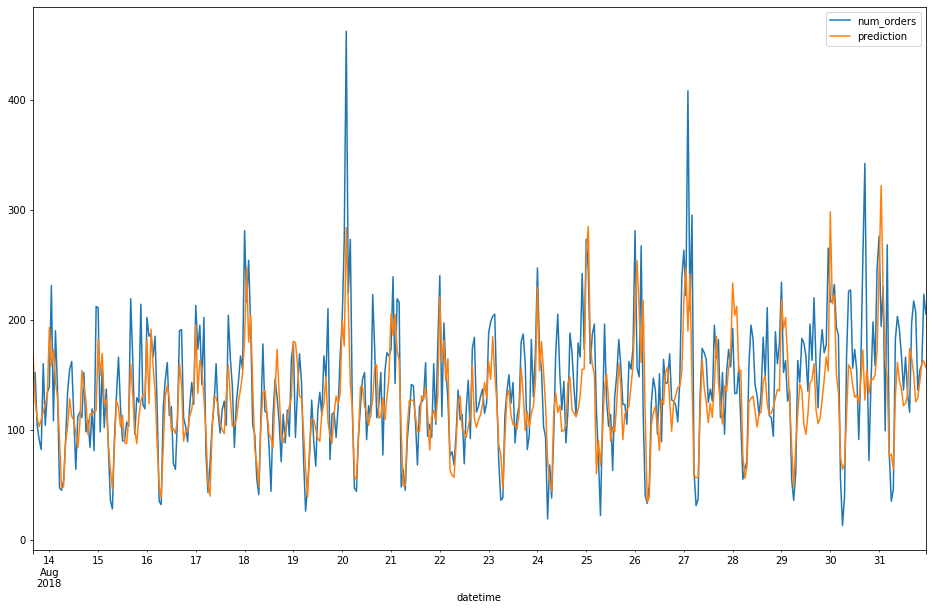

In [49]:
target_test.plot(figsize=(16,10),legend = True)
predictiongr.plot(figsize=(16,10),legend = True)

### NeuralProphet

In [45]:
m.test(test_m)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.784% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.042 32.053 44.056


,SmoothL1Loss,MAE,RMSE
0,0.04242,32.052578,44.056366


Результат тестирования соответствует требованию.

### Лучшая модель

Градиентный бустинг с подготовкой из sklearn дал немного более хороший результат, чем NeuralProphet. Осталось дообучить модель на полной базе.

In [50]:
features_train = data.drop(['num_orders'],axis = 1)
target_train = data['num_orders']

In [51]:
model = GradientBoostingRegressor(**params)

In [52]:
model.fit(features_train,target_train)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, random_state=13)

## Вывод

Данные были проанализированы и преобразованы для построения моделей. Опробованы две модели, из которых лучшей является градиентный бустинг из библиотеки skrlearn с предподготовкой данных. NeuralProphet дал результат немного хуже.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48